#  Q-learning

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Саттон Р.	С.,	Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/
* https://en.wikipedia.org/wiki/Q-learning
* https://www.baeldung.com/cs/epsilon-greedy-q-learning
* https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/
* https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial
* https://rubikscode.net/2021/07/20/introduction-to-double-q-learning/
* https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.RecordVideo

## Задачи для совместного разбора

1\. Рассмотрите понятие Q-функции, ее применение для формирования политики агента и способов ее создания.

In [1]:
import numpy as np

states = [0, 1, 2]
actions = [0, 1]

q_table = np.random.uniform(0, 100, size=(len(states), len(actions)))

In [2]:
current_state = 0
q_table[current_state]

array([66.31777161, 36.5998447 ])

In [3]:
q_table[current_state].argmax()

0

In [4]:
states = np.array([
    [0.5, 0.7],
    [1.2, 0.3],
    [-5.2, 0.1],
    [2.0, -3.0],
])

actions = [0, 1]

In [5]:
np.digitize(states[:, 0], bins=[-6, 0, 2])

array([2, 2, 1, 3])

In [6]:
np.digitize(states, bins=[-6, 0, 4])

array([[2, 2],
       [2, 2],
       [1, 2],
       [2, 1]])

In [7]:
import numpy as np

actions = [0, 1]

q_table = np.random.uniform(0, 100, size=(3, 3, len(actions)))

In [8]:
state = [1, 1]
q_table[1, 1]

array([ 3.00357083, 44.18159616])

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Обучите агента для игры в блэкджек (окружение `Blackjack-v1`), используя алгоритм Q-learning. Для создания таблицы Q-функции выясните размеры пространства состояния игры и количество возможных действий игрока и выведите эти значения на экран. Во время обучения несколько раз вычислите статистику за `print_every` последних эпизодов: количество выигранных и проигранных сессий. После завершения обучения визуализируйте полученные данные. Изучите, как выглядит Q-функция (в каких состояниях игрок будет брать карту, в каких - нет). Cыграйте `N=10000` игр, применяя стратегию, выведенную из обученной Q-функции, посчитайте и выведите на экран долю выигранных игр.

Cтратегия для выбора действия:
$$a_{t+1}(s_t) = argmax_aQ(s_t, a)$$

Правило обновления Q-функции:

![q-learning](https://wikimedia.org/api/rest_v1/media/math/render/svg/d247db9eaad4bd343e7882ec546bf3847ebd36d8)

- [x] Проверено на семинаре

In [9]:
from dataclasses import dataclass

@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: float = 100_000
    print_every: int = 5000

In [10]:
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm

class Agent:
    def __init__(self, env: gym.Env, config: Config) -> None:
        self.env = env
        self.cfg = config
        self._create_q_table()

    def _create_q_table(self):
        # напишите код для создания таблицы Q-функции
        # для окружения Blackjack должен получиться массив 32x11x2x2
        
        self.q_table = np.zeros((32, 11, 2, 2))
        print(self.q_table.shape)

    def get_action(self, state: np.ndarray | tuple) -> int:
        # найдите и верните индекс максимума Q-функции для состояния state
        # обратите внимание, что максимумов может быть несколько
        
        player_sum, dealer_card, ace = state
        return np.argmax(self.q_table[player_sum, dealer_card, ace])

    def update_q_table(
        self,
        state: np.ndarray | tuple,
        new_state: np.ndarray | tuple,
        reward: float, action: int,
        done: bool
    ) -> None:
        # напишите код для обновления Q-функции согласно правилу выше
        # если эпизод закончен, то будущая награда равна 0
        
        p_sum, d_card, ace = state
        n_p_sum, n_d_card, n_ace = new_state
        
        if not done:
            max_future_q = np.max(self.q_table[n_p_sum, n_d_card, n_ace])
        else:
            max_future_q = 0

        self.q_table[p_sum, d_card, ace, action] = (1 - self.cfg.lr) * self.q_table[p_sum, d_card, ace, action] + \
            self.cfg.lr * (reward + self.cfg.discount * max_future_q)

    def run_episode(self) -> float:
        done = False
        state, info = self.env.reset()
        while not done:
            action = self.get_action(state)
            new_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.update_q_table(state, new_state, reward, action, done)
            state = new_state

            if done:
                return reward

    def train(self):
        # допишите код для сбора статистики

        ep_rewards, stats = [], []
        loop = tqdm(range(self.cfg.n_episodes))
        for ep in loop:
            reward = self.run_episode()
            ep_rewards.append(reward)

            if (ep + 1) % self.cfg.print_every == 0:
                win_rate = np.sum(np.array(ep_rewards[-self.cfg.print_every:]) > 0) / self.cfg.print_every
                loss_rate = np.sum(np.array(ep_rewards[-self.cfg.print_every:]) < 0) / self.cfg.print_every
                draw_rate = np.sum(np.array(ep_rewards[-self.cfg.print_every:]) == 0) / self.cfg.print_every
                stats.append((ep + 1, win_rate, loss_rate, draw_rate))

                loop.set_postfix_str(f'Episode {ep + 1}: Win rate {win_rate*100:.2f}, Loss rate {loss_rate*100:.2f}, Draw rate {draw_rate*100:.2f}')
                
        return ep_rewards, stats

In [11]:
env = gym.make('Blackjack-v1')
config = Config()
agent = Agent(env, config)
rewards, stats = agent.train()
stats

(32, 11, 2, 2)


100%|██████████| 100000/100000 [00:05<00:00, 18662.98it/s, Episode 100000: Win rate 40.64, Loss rate 50.00, Draw rate 9.36]


[(5000, 0.407, 0.5188, 0.0742),
 (10000, 0.4116, 0.5032, 0.0852),
 (15000, 0.4142, 0.5026, 0.0832),
 (20000, 0.4194, 0.4964, 0.0842),
 (25000, 0.4212, 0.4978, 0.081),
 (30000, 0.4166, 0.5008, 0.0826),
 (35000, 0.4186, 0.5006, 0.0808),
 (40000, 0.4246, 0.4916, 0.0838),
 (45000, 0.4276, 0.489, 0.0834),
 (50000, 0.4146, 0.501, 0.0844),
 (55000, 0.4208, 0.4998, 0.0794),
 (60000, 0.4184, 0.4976, 0.084),
 (65000, 0.414, 0.498, 0.088),
 (70000, 0.4338, 0.4798, 0.0864),
 (75000, 0.4242, 0.4926, 0.0832),
 (80000, 0.4206, 0.4928, 0.0866),
 (85000, 0.4194, 0.499, 0.0816),
 (90000, 0.4188, 0.5034, 0.0778),
 (95000, 0.4298, 0.4762, 0.094),
 (100000, 0.4064, 0.5, 0.0936)]

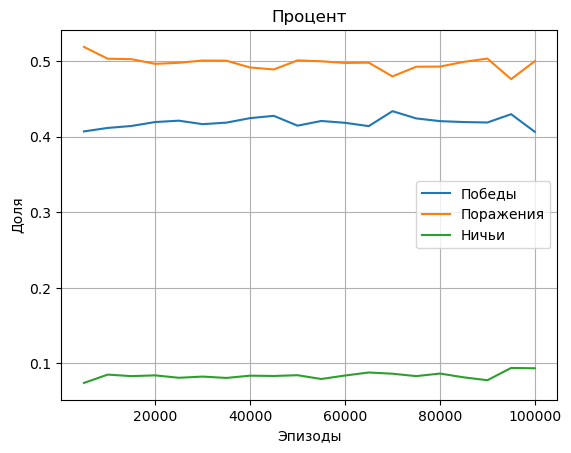

In [12]:
episodes, win_rates, loss_rate, draw_rate = zip(*stats)
plt.plot(episodes, win_rates, label='Победы')
plt.plot(episodes, loss_rate, label='Поражения')
plt.plot(episodes, draw_rate, label='Ничьи')
plt.title('Процент')
plt.xlabel('Эпизоды')
plt.ylabel('Доля')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
N = 10000
wins = 0
loop = tqdm(range(N))
for i in loop:
    state, _ = env.reset()
    done = False

    while not done:
        action = agent.get_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    if reward > 0:
        wins += 1
    
    loop.set_postfix_str(f'Победы {wins / (i + 1) * 100:.2f}%')

print(f'Процент побед: {wins / N * 100:.2f}%')

100%|██████████| 10000/10000 [00:06<00:00, 1579.93it/s, Победы 42.19%]

Процент побед: 42.19%


<p class="task" id="2"></p>

2\. Повторите решение предыдущей задачи, используя алгоритм $\epsilon$-greedy Q-learning. Исследуйте, как гиперпараметры и способ инициализации значений Q-функции влияют на результат.

Cтратегия для выбора действия:
1. Сгенерировать число $p$ из $U(0, 1)$;
2. Если $p < \epsilon$, то выбрать действие случайным образом;
3. В противном случае $a_{t+1}(s_t) = argmax_aQ(s_t, a)$.

Правило обновления Q-функции:
![q-learning](https://wikimedia.org/api/rest_v1/media/math/render/svg/d247db9eaad4bd343e7882ec546bf3847ebd36d8)

- [x] Проверено на семинаре

In [14]:
from dataclasses import dataclass

@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: float = 1_000_000
    epsilon: float = 1.0
    final_epsilon: float = 0.0
    print_every: int = 5000

In [16]:
class Agent:
    def __init__(self, env: gym.Env, config: Config, table_method='zeros') -> None:
        self.env = env
        self.cfg = config
        self._create_q_table(table_method)
        self.epsilon_decay = (config.epsilon - config.final_epsilon) / config.n_episodes

    def _create_q_table(self, table_method):
        # напишите код для создания таблицы Q-функции
        # для окружения Blackjack должен получиться массив 32x11x2x2
        
        match table_method:
            case 'zeros':
                self.q_table = np.zeros((32, 11, 2, 2))
            case 'uniform':
                self.q_table = np.random.uniform(0, 1, size=(32, 11, 2, 2))
            case 'normal':
                self.q_table = np.random.normal(0, 1, size=(32, 11, 2, 2))

    def get_action(self, state: np.ndarray | tuple) -> int:
        # найдите и верните индекс максимума Q-функции для состояния state
        # обратите внимание, что максимумов может быть несколько
        
        player_sum, dealer_card, ace = state
        p = np.random.uniform(0, 1)

        if p < self.cfg.epsilon:
            action = np.random.choice(self.env.action_space.n)
        else:
            action = np.argmax(self.q_table[player_sum, dealer_card, ace])
        
        return action

    def update_q_table(
        self,
        state: np.ndarray | tuple,
        new_state: np.ndarray | tuple,
        reward: float, action: int,
        done: bool
    ) -> None:
        # напишите код для обновления Q-функции согласно правилу выше
        # если эпизод закончен, то будущая награда равна 0
        
        p_sum, d_card, ace = state
        n_p_sum, n_d_card, n_ace = new_state

        if not done:
            max_future_q = np.max(self.q_table[n_p_sum, n_d_card, n_ace])
        else:
            max_future_q = 0

        self.q_table[p_sum, d_card, ace, action] = (1 - self.cfg.lr) * self.q_table[p_sum, d_card, ace, action] + \
            self.cfg.lr * (reward + self.cfg.discount * max_future_q)
    
    def update_epsilon(self):
        self.cfg.epsilon = max(self.cfg.final_epsilon, self.cfg.epsilon - self.epsilon_decay)

    def run_episode(self) -> float:
        done = False
        state, info = self.env.reset()
        while not done:
            action = self.get_action(state)
            new_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.update_q_table(state, new_state, reward, action, done)
            state = new_state
            self.update_epsilon()

            if done:
                return reward

    def train(self):
        # допишите код для сбора статистики

        ep_rewards, stats = [], []
        loop = tqdm(range(self.cfg.n_episodes))
        for ep in loop:
            reward = self.run_episode()
            ep_rewards.append(reward)

            if (ep + 1) % self.cfg.print_every == 0:
                win_rate = np.sum(np.array(ep_rewards[-self.cfg.print_every:]) > 0) / self.cfg.print_every
                loss_rate = np.sum(np.array(ep_rewards[-self.cfg.print_every:]) < 0) / self.cfg.print_every
                draw_rate = np.sum(np.array(ep_rewards[-self.cfg.print_every:]) == 0) / self.cfg.print_every
                stats.append((ep + 1, win_rate, loss_rate, draw_rate))

                loop.set_postfix_str(f'Episode {ep + 1}: Win rate {win_rate*100:.2f}, Loss rate {loss_rate*100:.2f}, Draw rate {draw_rate*100:.2f}')
                
        return ep_rewards, stats

In [17]:
def draw(stats, label):
    episodes, win_rates, loss_rate, draw_rate = zip(*stats)
    plt.plot(episodes, win_rates, label='Победы')
    plt.plot(episodes, loss_rate, label='Поражения')
    plt.plot(episodes, draw_rate, label='Ничьи')
    plt.title(f'Процент {label}')
    plt.xlabel('Эпизоды')
    plt.ylabel('Доля')
    plt.grid(True)
    plt.legend()
    plt.show()

In [18]:
env = gym.make('Blackjack-v1')
config = Config()

100%|██████████| 1000000/1000000 [00:56<00:00, 17769.47it/s, Episode 1000000: Win rate 41.76, Loss rate 48.00, Draw rate 10.24]


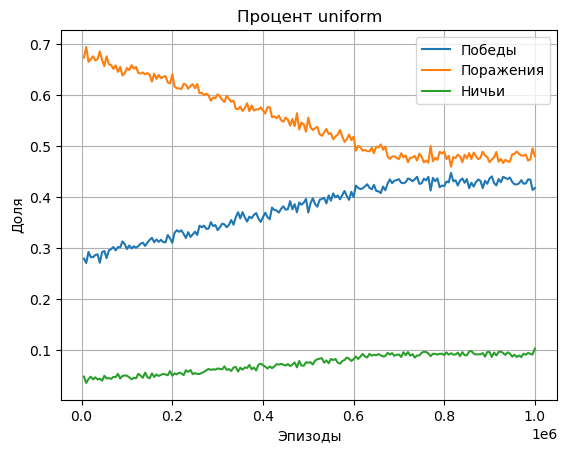

In [19]:
agent = Agent(env, config, table_method='uniform')
rewards, stats = agent.train()
draw(stats, label='uniform')

100%|██████████| 1000000/1000000 [00:50<00:00, 19760.84it/s, Episode 1000000: Win rate 38.96, Loss rate 54.78, Draw rate 6.26]


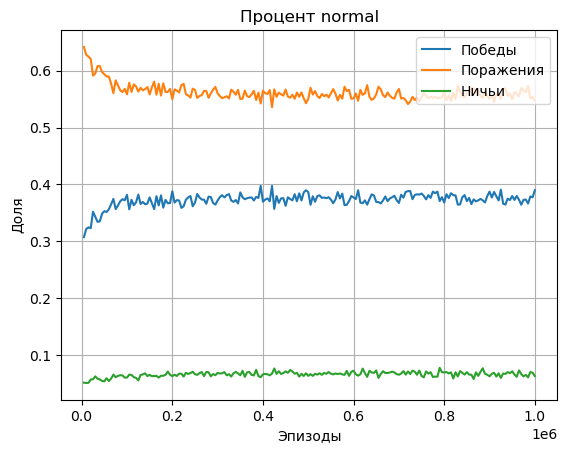

In [19]:
agent = Agent(env, config, table_method='normal')
rewards, stats = agent.train()
draw(stats, label='normal')

100%|██████████| 1000000/1000000 [00:52<00:00, 18931.60it/s, Episode 1000000: Win rate 43.58, Loss rate 47.36, Draw rate 9.06]


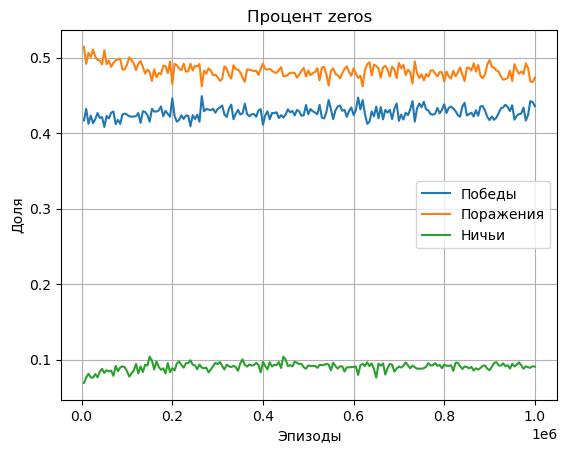

In [20]:
agent = Agent(env, config, table_method='zeros')
rewards, stats = agent.train()
draw(stats, label='zeros')

In [21]:
N = 10000
wins = 0
loop = tqdm(range(N))
for i in loop:
    state, _ = env.reset()
    done = False

    while not done:
        action = agent.get_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    if reward > 0:
        wins += 1
    
    loop.set_postfix_str(f'Победы {wins / (i + 1) * 100:.2f}%')

print(f'Процент побед: {wins / N * 100:.2f}%')

100%|██████████| 10000/10000 [00:06<00:00, 1555.38it/s, Победы 43.32%]

Процент побед: 43.32%
